In [3]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import (
    confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score,
    roc_curve, auc
)
from sklearn.calibration import CalibratedClassifierCV

np.random.seed(42)
random.seed(42)

In [4]:
# QUESTION 7: Dimensionality Reduction

DATA_PATH = "Project1-ClassificationDataset.csv"
df = pd.read_csv(DATA_PATH)

df = df[["full_text", "root_label", "leaf_label"]].copy()

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

print("Train size:", train_df.shape)
print("Test size:", test_df.shape)

train_texts = train_df["full_text"].astype(str).tolist()
test_texts  = test_df["full_text"].astype(str).tolist()

Train size: (2780, 3)
Test size: (696, 3)


In [5]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(train_df["root_label"])
y_test  = label_encoder.transform(test_df["root_label"])

print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Label mapping: {'climate': np.int64(0), 'sports': np.int64(1)}


In [6]:
# similar to Q3
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"", texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u ', " you ", texter)
    texter = re.sub('`', "", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ', texter)
    cleaner = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(cleaner, '', texter)
    if texter == "":
        texter = ""
    return texter

train_texts_clean = [clean(t) for t in train_texts]
test_texts_clean  = [clean(t) for t in test_texts]

import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

required_packages = [
    "punkt",
    "punkt_tab",
    "averaged_perceptron_tagger",
    "averaged_perceptron_tagger_eng",
    "wordnet",
    "omw-1.4"
]

for pkg in required_packages:
    try:
        nltk.data.find(pkg)
    except LookupError:
        nltk.download(pkg, quiet=True)

lemmatizer = WordNetLemmatizer()

def _to_wordnet_pos(treebank_tag: str):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    if treebank_tag.startswith('N'):
        return wordnet.NOUN
    if treebank_tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN

_num_like = re.compile(r"^[+-]?(\d+(\.\d*)?|\.\d+)$")

def lemma_tokenizer(text: str):
    tokens = word_tokenize(text.lower())
    tagged = pos_tag(tokens)

    lemmas = []
    for w, tag in tagged:
        if _num_like.match(w):
            continue

        if not any(ch.isalpha() for ch in w):
            continue

        wn_pos = _to_wordnet_pos(tag)
        lemmas.append(lemmatizer.lemmatize(w, pos=wn_pos))
    return lemmas

count_vec = CountVectorizer(
    stop_words="english",
    tokenizer=lemma_tokenizer,
    token_pattern=None,
    min_df=3
)

X_train_counts = count_vec.fit_transform(train_texts_clean)
X_test_counts  = count_vec.transform(test_texts_clean)

tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_counts)
X_test_tfidf  = tfidf.transform(X_test_counts)

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF test shape:", X_test_tfidf.shape)

c:\Users\AkhilManthina\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\feature_extraction\text.py:411: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make', 'u'] not in stop_words.
  warnings.warn(


TF-IDF train shape: (2780, 14250)
TF-IDF test shape: (696, 14250)


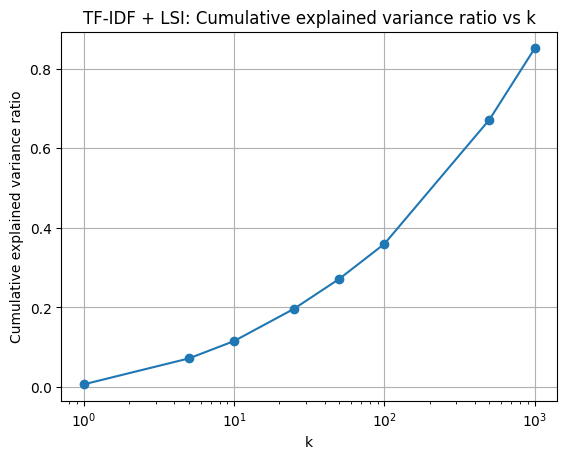

LSI k=25 train shape: (2780, 25)
LSI k=25 test shape: (696, 25)


In [7]:
# 7. a)

k_values = [1, 5, 10, 25, 50, 100, 500, 1000]
max_k = X_train_tfidf.shape[1] - 1

explained_variance_ratio = []
valid_k = []

for k in k_values:
    if k > max_k:
        continue

    svd = TruncatedSVD(n_components=k, random_state=42)
    svd.fit(X_train_tfidf)

    explained_variance_ratio.append(svd.explained_variance_ratio_.sum())
    valid_k.append(k)

plt.figure()
plt.plot(valid_k, explained_variance_ratio, marker="o")
plt.xscale("log")
plt.xlabel("k")
plt.ylabel("Cumulative explained variance ratio")
plt.title("TF-IDF + LSI: Cumulative explained variance ratio vs k")
plt.grid(True)
plt.show()

k = 25

svd_25 = TruncatedSVD(n_components=k, random_state=42)
X_train_lsi_25 = svd_25.fit_transform(X_train_tfidf)
X_test_lsi_25  = svd_25.transform(X_test_tfidf)

print(f"LSI k={k} train shape:", X_train_lsi_25.shape)
print(f"LSI k={k} test shape:", X_test_lsi_25.shape)

In [8]:
# 7. b)

def get_reconstruction_mse(X, X_hat):
    n, m = X.shape
    X_frob_sq = float(np.sum(X.data ** 2))
    Xhat_frob_sq = float(np.sum(X_hat ** 2))
    X_coo = X.tocoo()
    inner_prod = float(np.sum(X_coo.data * X_hat[X_coo.row, X_coo.col]))
    frob_diff_sq = X_frob_sq + Xhat_frob_sq - 2.0 * inner_prod
    return frob_diff_sq / (n * m)

X_train_lsi_hat = X_train_lsi_25 @ svd_25.components_
X_test_lsi_hat  = X_test_lsi_25  @ svd_25.components_

mse_lsi_train = get_reconstruction_mse(X_train_tfidf, X_train_lsi_hat)
mse_lsi_test  = get_reconstruction_mse(X_test_tfidf,  X_test_lsi_hat)

print("k = 25\n")
print("LSI reconstruction MSE:")
print("train:", mse_lsi_train)
print("test:", mse_lsi_test, '\n')

nmf_25 = NMF(n_components=25, init="nndsvda", random_state=42, max_iter=400)

W_train = nmf_25.fit_transform(X_train_tfidf)
W_test  = nmf_25.transform(X_test_tfidf)
H = nmf_25.components_

print("NMF train shape:", W_train.shape)
print("NMF test shape:", W_test.shape)

X_train_nmf_hat = W_train @ H
X_test_nmf_hat  = W_test  @ H

mse_nmf_train = get_reconstruction_mse(X_train_tfidf, X_train_nmf_hat)
mse_nmf_test  = get_reconstruction_mse(X_test_tfidf,  X_test_nmf_hat)

print("NMF reconstruction MSE:")
print("  train:", mse_nmf_train)
print("  test :", mse_nmf_test)

if mse_lsi_train < mse_nmf_train:
    smaller = "LSI"
else:
    smaller = "NMF"

print("\nSmaller reconstruction error:", smaller)
print("LSI/TruncatedSVD does not have a nonnegativity constraint. NMF is constrained to nonnegative factors, so it usually cannot match the optimal SVD reconstruction error.")


k = 25

LSI reconstruction MSE:
train: 5.462810586602354e-05
test: 5.613464262285956e-05 

NMF train shape: (2780, 25)
NMF test shape: (696, 25)
NMF reconstruction MSE:
  train: 5.502233200703569e-05
  test : 5.6352561169214326e-05

Smaller reconstruction error: LSI
LSI/TruncatedSVD does not have a nonnegativity constraint. NMF is constrained to nonnegative factors, so it usually cannot match the optimal SVD reconstruction error.


In [9]:
# 7. c) optional
# based on either GLoVE or LLM embeddings

SVM γ=2000
Confusion Matrix:
[[309  19]
 [ 19 349]]
Accuracy: 0.9454022988505747
Recall: 0.9483695652173914
Precision: 0.9483695652173914
F1-score: 0.9483695652173914

SVM γ=0.0005
Confusion Matrix:
[[299  29]
 [ 18 350]]
Accuracy: 0.9324712643678161
Recall: 0.9510869565217391
Precision: 0.9234828496042217
F1-score: 0.9370816599732262

SVM γ=100000
Confusion Matrix:
[[309  19]
 [ 19 349]]
Accuracy: 0.9454022988505747
Recall: 0.9483695652173914
Precision: 0.9483695652173914
F1-score: 0.9483695652173914



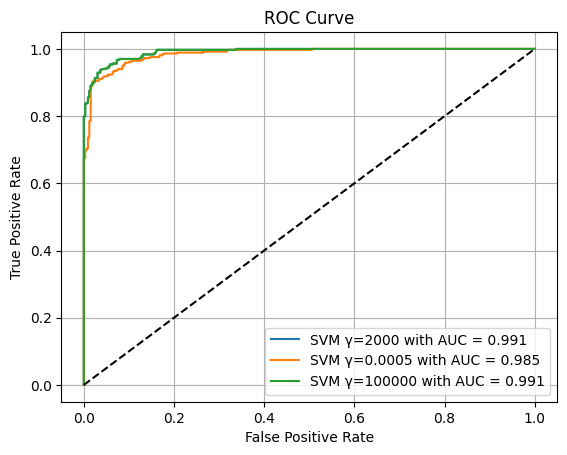

In [10]:
# 8. a)

def analyze_svm(model, test_features, test_labels, model_name=""):
    predicted_labels = model.predict(test_features)
    predicted_probabilities = model.predict_proba(test_features)[:, 1]

    conf_matrix = confusion_matrix(test_labels, predicted_labels)

    accuracy = accuracy_score(test_labels, predicted_labels)
    recall = recall_score(test_labels, predicted_labels)
    precision = precision_score(test_labels, predicted_labels)
    f1_score_ = f1_score(test_labels, predicted_labels)

    false_positive_rate, true_positive_rate, _ = roc_curve(test_labels, predicted_probabilities)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    print(model_name)
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1-score: {f1_score_}\n")

    plt.plot(
        false_positive_rate,
        true_positive_rate,
        label=f"{model_name} with AUC = {roc_auc:.3f}"
    )

plt.figure()
gammas = [2000, 0.0005, 100000]
for gamma in gammas:
    base_svm = LinearSVC(C=gamma, dual=False, max_iter=5000)
    svm = CalibratedClassifierCV(base_svm)
    svm.fit(X_train_lsi_25, y_train)
    analyze_svm(svm, X_test_lsi_25, y_test, model_name=f"SVM γ={gamma}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()



Which SVM performs better?

    The SVM with γ = 2000 (hard margin) performs better.
    It achieves higher accuracy and F1-score than the soft-margin SVM. The confusion matrix is also more balanced with fewer misclassifications.

What about γ = 100000?

    The SVM with γ = 100000 performs identically to γ = 2000.
    This means the classifier has already reached a stable maximum-margin solution, so increasing γ affect performance.

What happens for the soft margin SVM? Why?

    The soft margin SVM does not perform as well because it under-regularizes the margin constraint.

    The confusion matrix has more false positives (29 vs. 19), which lowers the overall accuracy and precision. Since the classifier is too lenient, we get more points that cross the margin and we get more classification errors.

Does the ROC curve reflect the performance of the soft-margin SVM? Why?

    Not completely. ROC curve evaluates ranking across thresholds, but the confusion matrix shows worse performance at a
     decision threshold.

In [11]:
# 8. b)

gammas = [10**k for k in range(-3, 7)]
avg_cv_accuracy = []

for gamma in gammas:
    svm = LinearSVC(C=gamma, dual=False, max_iter=5000)
    scores = cross_val_score(svm, X_train_lsi_25, y_train, cv=5, scoring="accuracy")
    avg_cv_accuracy.append(scores.mean())

best_gamma = gammas[int(np.argmax(avg_cv_accuracy))]

print("Gammas:", gammas)
print("Avg CV accuracy:", [round(x, 4) for x in avg_cv_accuracy])
print("Best gamma:", best_gamma)

Gammas: [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]
Avg CV accuracy: [np.float64(0.9342), np.float64(0.9338), np.float64(0.9388), np.float64(0.946), np.float64(0.9514), np.float64(0.9514), np.float64(0.9518), np.float64(0.9518), np.float64(0.9518), np.float64(0.9518)]
Best gamma: 1000


In [13]:
base_svm = LinearSVC(C=best_gamma, dual=False, max_iter=5000)
best_svm = CalibratedClassifierCV(base_svm)
best_svm.fit(X_train_lsi_25, y_train)

predicted_labels = best_svm.predict(X_test_lsi_25)
predicted_probs  = best_svm.predict_proba(X_test_lsi_25)[:, 1]

conf_matrix = confusion_matrix(y_test, predicted_labels)

accuracy = accuracy_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1-score: {f1}")

Confusion Matrix:
[[309  19]
 [ 19 349]]
Accuracy: 0.9454022988505747
Recall: 0.9483695652173914
Precision: 0.9483695652173914
F1-score: 0.9483695652173914


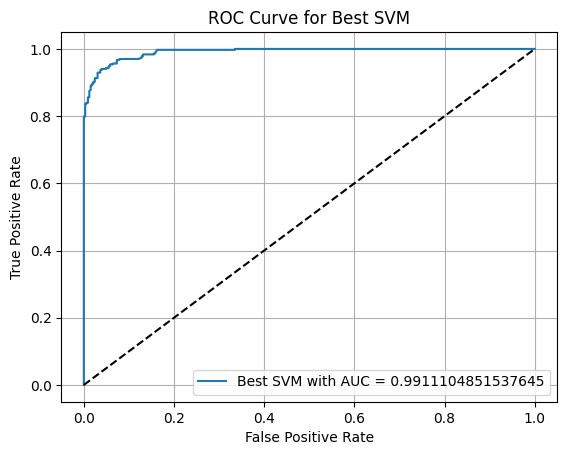

In [14]:
false_positive_rate, true_positive_rate, _ = roc_curve(y_test, predicted_probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure()
plt.plot(false_positive_rate, true_positive_rate, label=f"Best SVM with AUC = {roc_auc}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Best SVM")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# 9. a)

def analyze_logistic_classifier(model, test_features, test_labels, model_name=""):
    predicted_labels = model.predict(test_features)
    predicted_probs = model.predict_proba(test_features)[:, 1]

    conf_matrix = confusion_matrix(test_labels, predicted_labels)

    accuracy = accuracy_score(test_labels, predicted_labels)
    recall = recall_score(test_labels, predicted_labels)
    precision = precision_score(test_labels, predicted_labels)
    f1 = f1_score(test_labels, predicted_labels)

    false_positive_rate, true_positive_rate, _ = roc_curve(test_labels, predicted_probs)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    print(model_name)
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1-score: {f1}\n")

    plt.plot(false_positive_rate, true_positive_rate, label=f"{model_name} with AUC={roc_auc:.3f}")

LogReg (no regularization)
Confusion Matrix:
[[310  18]
 [ 18 350]]
Accuracy: 0.9482758620689655
Recall: 0.9510869565217391
Precision: 0.9510869565217391
F1-score: 0.9510869565217391



c:\Users\AkhilManthina\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


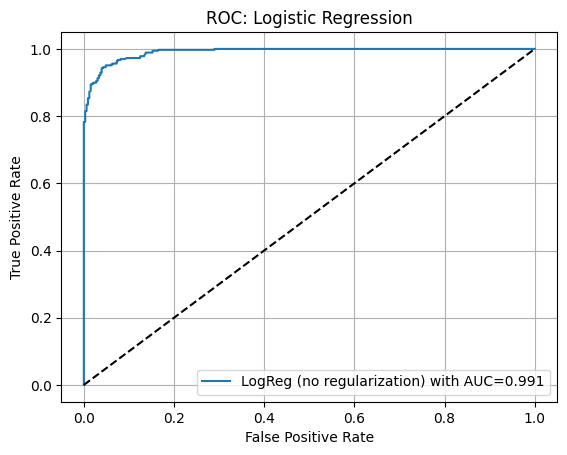

In [16]:
# Train a logistic classifier without regularization
no_regurlarization_logreg = LogisticRegression(penalty="l2", C=1e9, solver="lbfgs",max_iter=5000)
no_regurlarization_logreg.fit(X_train_lsi_25, y_train)

plt.figure()
analyze_logistic_classifier(no_regurlarization_logreg, X_test_lsi_25, y_test, "LogReg (no regularization)")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC: Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# 9. b) Find the optimal regularization coefficient

coefficients = [10**k for k in range(-5, 6)]

def find_optimal_regularization_coefficient(penalty_type):
    best_C = None
    best_cv_accuracy = -100.0

    for C in coefficients:
        if penalty_type == "l1":
            model = LogisticRegression(penalty="l1", C=C, solver="liblinear", max_iter=5000)
        else:
            model = LogisticRegression(penalty="l2", C=C, solver="lbfgs", max_iter=5000)

        scores = cross_val_score(model, X_train_lsi_25, y_train, cv=5, scoring="accuracy")
        avg_score = scores.mean()

        if avg_score > best_cv_accuracy:
            best_cv_accuracy = avg_score
            best_C = C

    return best_C, best_cv_accuracy

best_C_l1, best_acc_l1 = find_optimal_regularization_coefficient("l1")
best_C_l2, best_acc_l2 = find_optimal_regularization_coefficient("l2")

# 9. b) 1.
print("Optimal regularization coefficient for L1:", best_C_l1, "CV accuracy:", round(best_acc_l1, 4))
print("Optimal regularization coefficient for L2:", best_C_l2, "CV accuracy:", round(best_acc_l2, 4))

c:\Users\AkhilManthina\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\AkhilManthina\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
c:\Users\AkhilManthina\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_rat

Optimal regularization coefficient for L1: 100 CV accuracy: 0.9514
Optimal regularization coefficient for L2: 100 CV accuracy: 0.9522


c:\Users\AkhilManthina\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\AkhilManthina\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\AkhilManthina\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWar

LogReg (no regularization)
Confusion Matrix:
[[310  18]
 [ 18 350]]
Accuracy: 0.9482758620689655
Recall: 0.9510869565217391
Precision: 0.9510869565217391
F1-score: 0.9510869565217391

LogReg L1, C=100
Confusion Matrix:
[[310  18]
 [ 18 350]]
Accuracy: 0.9482758620689655
Recall: 0.9510869565217391
Precision: 0.9510869565217391
F1-score: 0.9510869565217391

LogReg L2, C=100
Confusion Matrix:
[[309  19]
 [ 19 349]]
Accuracy: 0.9454022988505747
Recall: 0.9483695652173914
Precision: 0.9483695652173914
F1-score: 0.9483695652173914



c:\Users\AkhilManthina\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\AkhilManthina\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
c:\Users\AkhilManthina\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_rat

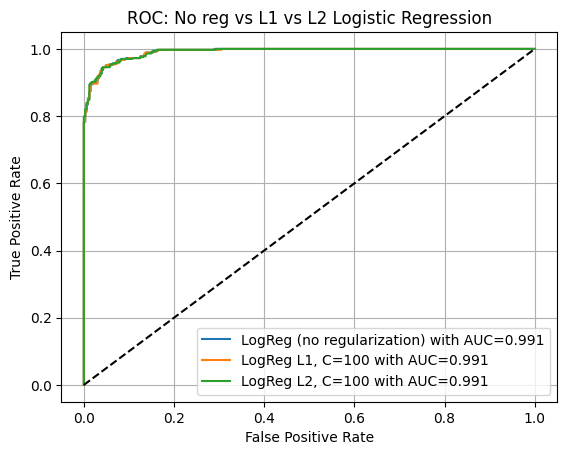

In [18]:
best_l1_logreg = LogisticRegression(penalty="l1", C=best_C_l1, solver="liblinear", max_iter=5000)
best_l2_logreg = LogisticRegression(penalty="l2", C=best_C_l2, solver="lbfgs", max_iter=5000)

best_l1_logreg.fit(X_train_lsi_25, y_train)
best_l2_logreg.fit(X_train_lsi_25, y_train)

plt.figure()
analyze_logistic_classifier(no_regurlarization_logreg,  X_test_lsi_25, y_test, "LogReg (no regularization)")
analyze_logistic_classifier(best_l1_logreg, X_test_lsi_25, y_test, f"LogReg L1, C={best_C_l1}")
analyze_logistic_classifier(best_l2_logreg, X_test_lsi_25, y_test, f"LogReg L2, C={best_C_l2}")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC: No reg vs L1 vs L2 Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()


9. b) 2.
Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classi-
fiers: w/o regularization, w/ L1 regularization and w/ L2 regularization

    All three models performed pretty much the same way. L2 performed slightly worse and the confusion matrices were slightly different.

9. b) 3. 

How does the regularization parameter affect the test error?

    No substantial affect since the classes are already split after TF-IDF + LSI

How are the learnt coefficients affected?

    L1 makes some of the coefficients zero while L2 shrinks them in a stable manner.

Why might one be interested in each type of regularization?

    L1 is good for selecting features, L2 for better stability and robustness, and no regularization when you want it faster when there is no
    need to avoid overfitting.

9. b) 4.

Both logistic regression and linear SVM are trying to classify data points using a linear
decision boundary.

What is the difference between their ways to find this boundary?

    Logistic regression finds the boundary by maximizing the conditional likelihood. SVM maximizes the margins between each class instead.

Why do their performances differ?

    Logistic regression fits over all points and SVM only fits on the boundary support vectors.

Is this difference statistically significant?

    Based on the findings above, the difference is not significant.

In [ ]:
# Helper for 10 and 12
def analyze_classifier(model, test_features, test_labels, model_name=''):
    """Analyze classifier performance and plot ROC curve"""
    predicted_labels = model.predict(test_features)
    
    # Get probability scores for ROC curve
    if hasattr(model, 'predict_proba'):
        predicted_probs = model.predict_proba(test_features)[:, 1]
    elif hasattr(model, 'decision_function'):
        predicted_probs = model.decision_function(test_features)
    else:
        predicted_probs = predicted_labels

    conf_matrix = confusion_matrix(test_labels, predicted_labels)
    accuracy = accuracy_score(test_labels, predicted_labels)
    recall = recall_score(test_labels, predicted_labels)
    precision = precision_score(test_labels, predicted_labels)
    f1 = f1_score(test_labels, predicted_labels)

    fpr, tpr, _ = roc_curve(test_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    print(model_name)
    print('Confusion Matrix:')
    print(conf_matrix)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print()

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')
    return accuracy, recall, precision, f1, roc_auc

GaussianNB (LSI features)
Confusion Matrix:
[[280  48]
 [ 10 358]]
Accuracy: 0.9167
Recall: 0.9728
Precision: 0.8818
F1-score: 0.9251
ROC AUC: 0.9742



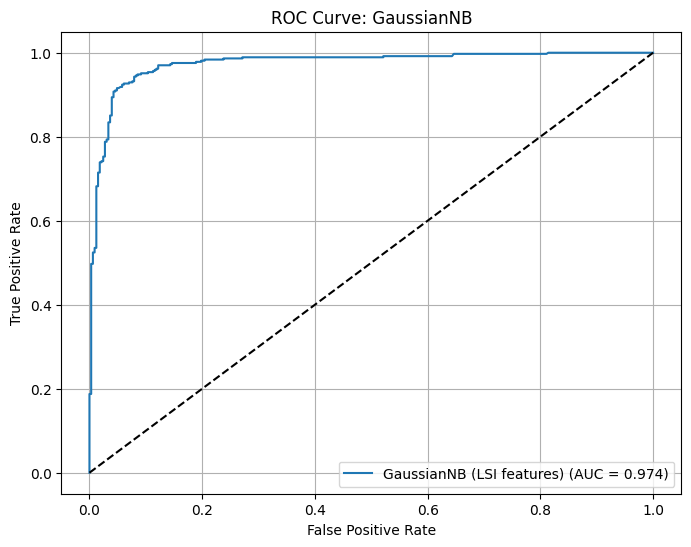

In [ ]:
# QUESTION 10: Naive Bayes (GaussianNB)
from sklearn.naive_bayes import GaussianNB


gnb = GaussianNB()
gnb.fit(X_train_lsi_25, y_train)

plt.figure(figsize=(8, 6))
analyze_classifier(gnb, X_test_lsi_25, y_test, 'GaussianNB (LSI features)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: GaussianNB')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# QUESTION 11: GridSearch Pipeline for Binary Classification
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings('ignore')

class DenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if hasattr(X, 'toarray'):
            return X.toarray()
        return X

from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stem_tokenizer(text):
    tokens = word_tokenize(text.lower())
    tagged = pos_tag(tokens)
    
    stems = []
    for w, tag in tagged:
        if _num_like.match(w):
            continue
        if not any(ch.isalpha() for ch in w):
            continue
        stems.append(stemmer.stem(w))
    return stems

#Q8
best_svm_gamma = 2000
#Q9
best_lr_l1_C = 100
best_lr_l2_C = 100

param_grid_sparse = [
    # SVM configurations
    {
        'vect__min_df': [2, 5],
        'dim_red': [TruncatedSVD(n_components=5), TruncatedSVD(n_components=30), TruncatedSVD(n_components=100),
                    NMF(n_components=5, max_iter=200), NMF(n_components=30, max_iter=200), NMF(n_components=100, max_iter=200)],
        'clf': [LinearSVC(C=1.0/best_svm_gamma, max_iter=2000, dual='auto')],
    },
    # Logistic Regression L1
    {
        'vect__min_df': [2, 5],
        'dim_red': [TruncatedSVD(n_components=5), TruncatedSVD(n_components=30), TruncatedSVD(n_components=100),
                    NMF(n_components=5, max_iter=200), NMF(n_components=30, max_iter=200), NMF(n_components=100, max_iter=200)],
        'clf': [LogisticRegression(penalty='l1', C=best_lr_l1_C, solver='liblinear', max_iter=1000)],
    },
    # Logistic Regression L2
    {
        'vect__min_df': [2, 5],
        'dim_red': [TruncatedSVD(n_components=5), TruncatedSVD(n_components=30), TruncatedSVD(n_components=100),
                    NMF(n_components=5, max_iter=200), NMF(n_components=30, max_iter=200), NMF(n_components=100, max_iter=200)],
        'clf': [LogisticRegression(penalty='l2', C=best_lr_l2_C, solver='liblinear', max_iter=1000)],
    },
]

param_grid_dense = [
    # GaussianNB configurations
    {
        'vect__min_df': [2, 5],
        'dim_red': [TruncatedSVD(n_components=5), TruncatedSVD(n_components=30), TruncatedSVD(n_components=100),
                    NMF(n_components=5, max_iter=200), NMF(n_components=30, max_iter=200), NMF(n_components=100, max_iter=200)],
        'clf': [GaussianNB()],
    },
]

# Store all results
all_results = []

# Pipeline for sparse classifiers with LEMMATIZER
pipeline_sparse_lemma = Pipeline([
    ('vect', CountVectorizer(stop_words='english', tokenizer=lemma_tokenizer, token_pattern=None)),
    ('tfidf', TfidfTransformer()),
    ('dim_red', TruncatedSVD(n_components=5)),
    ('clf', LinearSVC())
])

# Pipeline for GaussianNB with LEMMATIZER
pipeline_dense_lemma = Pipeline([
    ('vect', CountVectorizer(stop_words='english', tokenizer=lemma_tokenizer, token_pattern=None)),
    ('tfidf', TfidfTransformer()),
    ('dim_red', TruncatedSVD(n_components=5)),
    ('to_dense', DenseTransformer()),
    ('clf', GaussianNB())
])

print('Gridsearch svm and logistic')
grid_sparse_lemma = GridSearchCV(
    pipeline_sparse_lemma,
    param_grid_sparse,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    verbose=2
)
grid_sparse_lemma.fit(train_texts_clean, y_train)

print('\nGridsearch gaussian')
grid_dense_lemma = GridSearchCV(
    pipeline_dense_lemma,
    param_grid_dense,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    verbose=2
)
grid_dense_lemma.fit(train_texts_clean, y_train)

import pandas as pd
results_sparse_lemma = pd.DataFrame(grid_sparse_lemma.cv_results_)
results_sparse_lemma['tokenizer'] = 'lemmatizer'
results_dense_lemma = pd.DataFrame(grid_dense_lemma.cv_results_)
results_dense_lemma['tokenizer'] = 'lemmatizer'
all_results.extend([results_sparse_lemma, results_dense_lemma])

# Pipeline for sparse classifiers with STEMMER
pipeline_sparse_stem = Pipeline([
    ('vect', CountVectorizer(stop_words='english', tokenizer=stem_tokenizer, token_pattern=None)),
    ('tfidf', TfidfTransformer()),
    ('dim_red', TruncatedSVD(n_components=5)),
    ('clf', LinearSVC())
])

# Pipeline for GaussianNB with STEMMER
pipeline_dense_stem = Pipeline([
    ('vect', CountVectorizer(stop_words='english', tokenizer=stem_tokenizer, token_pattern=None)),
    ('tfidf', TfidfTransformer()),
    ('dim_red', TruncatedSVD(n_components=5)),
    ('to_dense', DenseTransformer()),
    ('clf', GaussianNB())
])

print('\nGridsearch svm and logistic')
grid_sparse_stem = GridSearchCV(
    pipeline_sparse_stem,
    param_grid_sparse,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    verbose=2
)
grid_sparse_stem.fit(train_texts_clean, y_train)

print('\nGridsearch gaussian')
grid_dense_stem = GridSearchCV(
    pipeline_dense_stem,
    param_grid_dense,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    verbose=2
)
grid_dense_stem.fit(train_texts_clean, y_train)

results_sparse_stem = pd.DataFrame(grid_sparse_stem.cv_results_)
results_sparse_stem['tokenizer'] = 'stemmer'
results_dense_stem = pd.DataFrame(grid_dense_stem.cv_results_)
results_dense_stem['tokenizer'] = 'stemmer'
all_results.extend([results_sparse_stem, results_dense_stem])

# Combine results
all_results_df = pd.concat(all_results, ignore_index=True)
all_results_sorted = all_results_df.sort_values('mean_test_score', ascending=False)

print('\n' + '='*80)
print('TOP 5 5-fold CV ACC')
print('='*80)

# Display top 5
for idx, (i, row) in enumerate(all_results_sorted.head(5).iterrows(), 1):
    print(f'\nRank {idx}:')
    print(f"  CV Accuracy: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"  Parameters: {row['params']}")

print('\n' + '='*80)
print('TEST SET TOP 5 COMBINATIONS')
print('='*80)

test_results = []

for idx, (i, row) in enumerate(all_results_sorted.head(5).iterrows(), 1):
    print(f'\n--- Rank {idx} ---')
    params = row['params']
    tokenizer_type = row['tokenizer']
    
    clf = params.get('clf')
    if isinstance(clf, GaussianNB):
        if tokenizer_type == 'lemmatizer':
            pipeline = pipeline_dense_lemma
        else:
            pipeline = pipeline_dense_stem
    else:
        if tokenizer_type == 'lemmatizer':
            pipeline = pipeline_sparse_lemma
        else:
            pipeline = pipeline_sparse_stem
    
    pipeline.set_params(**params)
    pipeline.fit(train_texts_clean, y_train)
    
    y_pred = pipeline.predict(test_texts_clean)
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    
    test_acc = accuracy_score(y_test, y_pred)
    test_prec = precision_score(y_test, y_pred, average='binary')
    test_rec = recall_score(y_test, y_pred, average='binary')
    test_f1 = f1_score(y_test, y_pred, average='binary')
    conf_mat = confusion_matrix(y_test, y_pred)
    
    print(f'Parameters: {params}')
    print(f'\nTest Set Metrics:')
    print(f'  Accuracy:  {test_acc:.4f}')
    print(f'  Precision: {test_prec:.4f}')
    print(f'  Recall:    {test_rec:.4f}')
    print(f'  F1-Score:  {test_f1:.4f}')
    print(f'\nConfusion Matrix:')
    print(conf_mat)
    
    test_results.append({
        'rank': idx,
        'params': params,
        'cv_acc': row['mean_test_score'],
        'test_acc': test_acc,
        'test_prec': test_prec,
        'test_rec': test_rec,
        'test_f1': test_f1
    })

# Summary table
print('\n' + '='*80)
print('SUMMARY')
print('='*80)
summary_df = pd.DataFrame(test_results)
print(summary_df[['rank', 'cv_acc', 'test_acc', 'test_prec', 'test_rec', 'test_f1']].to_string(index=False))

Gridsearch svm and logistic
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Gridsearch gaussian
Fitting 5 folds for each of 24 candidates, totalling 120 fits

TOP 5 5-fold CV ACC

Rank 1:
  CV Accuracy: 0.9604 (+/- 0.0032)
  Parameters: {'clf': LogisticRegression(C=100, max_iter=1000, penalty='l2', solver='liblinear'), 'dim_red': TruncatedSVD(n_components=100), 'vect__min_df': 5, 'vect__tokenizer': <__main__.StemTokenizer object at 0x000002A3CC9F0EC0>}

Rank 2:
  CV Accuracy: 0.9601 (+/- 0.0053)
  Parameters: {'clf': LogisticRegression(C=100, max_iter=1000, penalty='l1', solver='liblinear'), 'dim_red': NMF(n_components=100, tol=0.01), 'vect__min_df': 2, 'vect__tokenizer': <__main__.StemTokenizer object at 0x000002A3CC9F0EC0>}

Rank 3:
  CV Accuracy: 0.9601 (+/- 0.0026)
  Parameters: {'clf': LogisticRegression(C=100, max_iter=1000, penalty='l2', solver='liblinear'), 'dim_red': TruncatedSVD(n_components=100), 'vect__min_df': 2, 'vect__tokenizer': <__main__.LemmaTokenizer o

In [ ]:
# TAKEN FROM QUESTION 5: GloVe Embeddings
import numpy as np
import os

embeddings_dict = {}
glove_path = 'glove.6B.300d.txt' 

print('Loading GloVe embeddings...')
if os.path.exists(glove_path):
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], 'float32')
            embeddings_dict[word] = vector
    print(f'Loaded {len(embeddings_dict)} word vectors.')
else:
    print(f'Error: {glove_path} not found. Please ensure the file is in the correct directory.')

def get_glove_embedding(text, embeddings_dict, dim=300):
    words = text.split()
    valid_vectors = []
    for w in words:
        if w in embeddings_dict:
            valid_vectors.append(embeddings_dict[w])
    
    if not valid_vectors:
        return np.zeros(dim)
    
    return np.mean(valid_vectors, axis=0)

print('Constructing GloVe document embeddings...')
if embeddings_dict:
    X_train_glove = np.array([get_glove_embedding(t, embeddings_dict) for t in train_texts_clean])
    X_test_glove = np.array([get_glove_embedding(t, embeddings_dict) for t in test_texts_clean])

    print('GloVe train shape:', X_train_glove.shape)
    print('GloVe test shape:', X_test_glove.shape)
else:
    X_train_glove = np.zeros((len(train_texts_clean), 300))
    X_test_glove = np.zeros((len(test_texts_clean), 300))
    print('GloVe embeddings dict empty, using zeros.')

Loading GloVe embeddings...
Loaded 400000 word vectors.
Constructing GloVe document embeddings...
GloVe train shape: (2780, 300)
GloVe test shape: (696, 300)


In [27]:
# TAKEN FROM QUESTION 6: LLM Embeddings
import torch
from transformers import AutoTokenizer, AutoModel

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'
MAX_LEN = 128
BATCH_SIZE = 32

print(f'Loading {MODEL_NAME}...')
try:
    tok = AutoTokenizer.from_pretrained(MODEL_NAME)
    enc = AutoModel.from_pretrained(MODEL_NAME).to(device)
    enc.eval()

    @torch.no_grad()
    def get_llm_embeddings(texts):
        all_vecs = []
        for i in range(0, len(texts), BATCH_SIZE):
            batch = texts[i:i+BATCH_SIZE]
            inputs = tok(
                batch,
                truncation=True,
                max_length=MAX_LEN,
                padding=True,
                return_tensors='pt'
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}
            out = enc(**inputs)
            
            # Mean pooling
            mask = inputs['attention_mask'].unsqueeze(-1).expand(out.last_hidden_state.size()).float()
            sum_embeddings = torch.sum(out.last_hidden_state * mask, 1)
            sum_mask = torch.clamp(mask.sum(1), min=1e-9)
            pooled = sum_embeddings / sum_mask
            
            all_vecs.append(pooled.cpu().numpy())
            
        return np.concatenate(all_vecs, axis=0)

    # Use raw texts for LLM
    print('Generating LLM embeddings for Train set...')
    X_train_llm = get_llm_embeddings(train_texts)
    print('Generating LLM embeddings for Test set...')
    X_test_llm = get_llm_embeddings(test_texts)

    print('LLM train shape:', X_train_llm.shape)
    print('LLM test shape:', X_test_llm.shape)

except Exception as e:
    print(f'Error loading/running LLM: {e}')
    # Fallback
    X_train_llm = np.zeros((len(train_texts), 384))
    X_test_llm = np.zeros((len(test_texts), 384))

Using device: cuda
Loading sentence-transformers/all-MiniLM-L6-v2...
Generating LLM embeddings for Train set...
Generating LLM embeddings for Test set...
LLM train shape: (2780, 384)
LLM test shape: (696, 384)


QUESTION 12: Representation Comparison
Building TF-IDF pipeline best
--------------------------------------------------------------------------------
TF-IDF (best pipeline) train shape: (2780, 100)
TF-IDF (best pipeline) test shape: (696, 100)

Setting up classifier
--------------------------------------------------------------------------------
Classifier for all representations: LogisticRegression(C=100, max_iter=1000, penalty='l2', random_state=42,
                   solver='liblinear')
--------------------------------------------------------------------------------
TF-IDF (Best from Q11)    - Train: (2780, 100), Test: (696, 100)
GloVe                     - Train: (2780, 300), Test: (696, 300)
LLM (MiniLM)              - Train: (2780, 384), Test: (696, 384)

EVALUATION RESULTS - ALL REPRESENTATIONS

--- Training on TF-IDF (Best from Q11) ---
TF-IDF (Best from Q11)
Confusion Matrix:
[[321   7]
 [ 14 354]]
Accuracy: 0.9698
Recall: 0.9620
Precision: 0.9806
F1-score: 0.9712
ROC AUC: 0.9

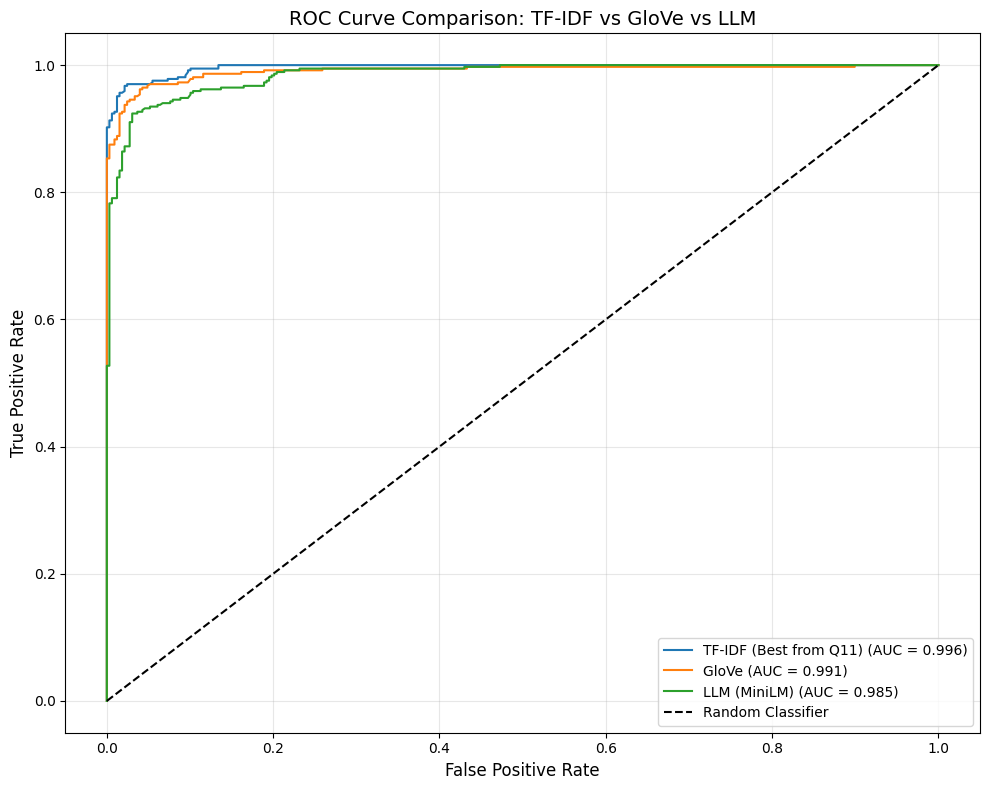


SUMMARY COMPARISON TABLE
        Representation  Accuracy  Precision   Recall  F1-Score
TF-IDF (Best from Q11)  0.969828   0.980609 0.961957  0.971193
                 GloVe  0.955460   0.969359 0.945652  0.957359
          LLM (MiniLM)  0.939655   0.952778 0.932065  0.942308

Best representation: TF-IDF (Best from Q11) (F1: 0.9712)
Worst representation: LLM (MiniLM) (F1: 0.9423)



In [ ]:
# QUESTION 12:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

print("="*80)
print("QUESTION 12: Representation Comparison")
print("="*80)


print("Building TF-IDF pipeline best")
print("-"*80)

# Use LemmaTokenizer (same as in Q11)
best_tfidf_pipeline = Pipeline([
    ('vect', CountVectorizer(
        stop_words='english',
        token_pattern=None,
        min_df=2,
        tokenizer=lemma_tokenizer
    )),
    ('tfidf', TfidfTransformer()),
    ('dim_red', TruncatedSVD(n_components=100))
])

X_train_tfidf_best = best_tfidf_pipeline.fit_transform(train_texts_clean, y_train)
X_test_tfidf_best = best_tfidf_pipeline.transform(test_texts_clean)

if hasattr(X_train_tfidf_best, 'toarray'):
    X_train_tfidf_best = X_train_tfidf_best.toarray()
    X_test_tfidf_best = X_test_tfidf_best.toarray()

print(f"TF-IDF (best pipeline) train shape: {X_train_tfidf_best.shape}")
print(f"TF-IDF (best pipeline) test shape: {X_test_tfidf_best.shape}")

print("\nSetting up classifier")
print("-"*80)

# Use LogisticRegression with L2 and C=100 (the best from Q11)
clf_q12 = LogisticRegression(
    penalty='l2',
    C=100,
    solver='liblinear',
    max_iter=1000,
    random_state=42
)
print(f"Classifier for all representations: {clf_q12}")


print("-"*80)

representations = {
    'TF-IDF (Best from Q11)': (X_train_tfidf_best, X_test_tfidf_best),
    'GloVe': (X_train_glove, X_test_glove),
    'LLM (MiniLM)': (X_train_llm, X_test_llm)
}

for name, (X_tr, X_te) in representations.items():
    print(f"{name:25s} - Train: {X_tr.shape}, Test: {X_te.shape}")


print("\n" + "="*80)
print("EVALUATION RESULTS - ALL REPRESENTATIONS")
print("="*80)

results_dict = {}
plt.figure(figsize=(10, 8))

for name, (X_tr, X_te) in representations.items():
    print(f'\n--- Training on {name} ---')
    
    # dim check
    if X_tr.shape[0] != y_train.shape[0]:
        print(f'ERROR: Skipping {name} due to dimension mismatch.')
        continue
    
    clf_q12.fit(X_tr, y_train)
    
    analyze_classifier(clf_q12, X_te, y_test, name)
    
    y_pred = clf_q12.predict(X_te)
    results_dict[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

# ROC plot
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison: TF-IDF vs GloVe vs LLM', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("SUMMARY COMPARISON TABLE")
print("="*80)

import pandas as pd

summary_data = []
for name, metrics in results_dict.items():
    summary_data.append({
        'Representation': name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1']
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

best_rep = max(results_dict.items(), key=lambda x: x[1]['f1'])
worst_rep = min(results_dict.items(), key=lambda x: x[1]['f1'])

print(f"\nBest representation: {best_rep[0]} (F1: {best_rep[1]['f1']:.4f})")
print(f"Worst representation: {worst_rep[0]} (F1: {worst_rep[1]['f1']:.4f})")

Running UMAP

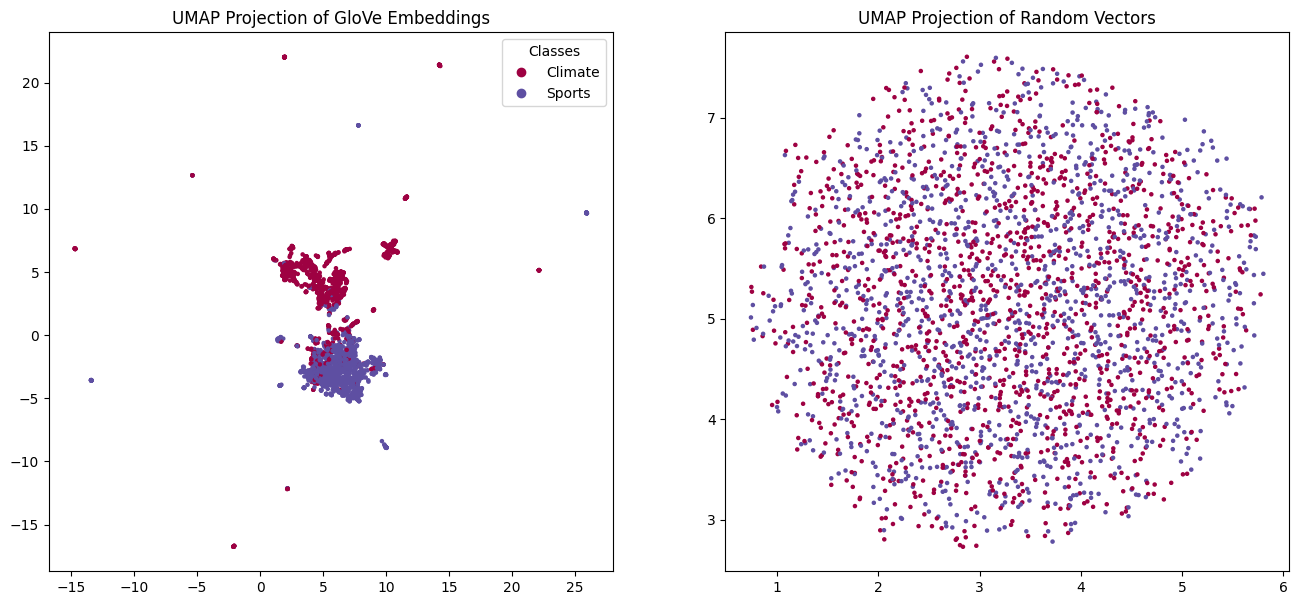

In [ ]:
# QUESTION 13 UMAP:
try:
    import umap.umap_ as umap
except ImportError:

    import subprocess
    import sys
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'umap-learn'])
        import umap.umap_ as umap
    except Exception as e:
        print(f'Failed to install/import umap: {e}. Visualization skipped.')
        umap = None

if umap:
    print("Running UMAP")
    reducer = umap.UMAP(random_state=42)
    embedding_glove = reducer.fit_transform(X_train_glove)
    X_random = np.random.rand(*X_train_glove.shape)
    embedding_random = reducer.fit_transform(X_random)

    fig, axs = plt.subplots(1, 2, figsize=(16, 7))
    scatter = axs[0].scatter(embedding_glove[:, 0], embedding_glove[:, 1], c=y_train, cmap='Spectral', s=5)
    axs[0].set_title('UMAP Projection of GloVe Embeddings')
    handles, _ = scatter.legend_elements(prop='colors')
    labels = ['Climate', 'Sports'] 
    axs[0].legend(handles, labels, title='Classes')

    #Random Plot
    axs[1].scatter(embedding_random[:, 0], embedding_random[:, 1], c=y_train, cmap='Spectral', s=5)
    axs[1].set_title('UMAP Projection of Random Vectors')

    plt.show()


### Question 13

The GloVe embeddings plot (left) shows two distinct, well-separated clusters corresponding to the Sports (blue) and Climate (pink) classes, with minimal overlap and only a few scattered outliers. The clusters are compact and clearly separable, indicating that GloVe embeddings successfully capture semantic meaning.